# Statoil/C-CORE Iceberg Classifier Challenge

**Summary :** Drifting icebergs present threats to navigation and activities in areas such as offshore of the East Coast of Canada.

Currently, many institutions and companies use aerial reconnaissance and shore-based support to monitor environmental conditions and assess risks from icebergs. However, in remote areas with particularly harsh weather, these methods are not feasible, and the only viable monitoring option is via satellite.

Statoil, an international energy company operating worldwide, has worked closely with companies like C-CORE. C-CORE have been using satellite data for over 30 years and have built a computer vision based surveillance system. To keep operations safe and efficient, Statoil is interested in getting a fresh new perspective on how to use machine learning to more accurately detect and discriminate against threatening icebergs as early as possible.

In this competition, you’re challenged to build an algorithm that automatically identifies if a remotely sensed target is a ship or iceberg. Improvements made will help drive the costs down for maintaining safe working conditions.

## Preliminaries and Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
plt.rcParams['figure.figsize'] = 10, 10  #default setting
from mpl_toolkits.axes_grid1 import ImageGrid
%matplotlib inline

## I. Load Data

- **Rq : ** Datasets are quite light, can be fully loaded in a laptop memory with ease.

In [2]:
%%time
train = pd.read_json('../data/processed/train.json')
test = pd.read_json('../data/processed/test.json')

CPU times: user 5.97 s, sys: 1.59 s, total: 7.56 s
Wall time: 9.07 s


- **Rq : ** Recast Numerical values into float as opposed to string encoding.

In [3]:
#recast inc_val as float
train['inc_angle'] = pd.to_numeric(train['inc_angle'],errors='coerce')
test['inc_angle'] = pd.to_numeric(test['inc_angle'],errors='coerce')

- **Data integrity check**

In [4]:
#data integrity check
#variable types
def summaryze(df):
    summary =  pd.DataFrame()
    summary["column"] = list(df.columns)
    summary["type"] = list(df.dtypes)
    summary["nb_missing_values"] = list(df.isnull().sum())
    summary["nb_missing_values%"] = summary["nb_missing_values"]/len(df)*100
    summary.set_index("column",inplace=True)
    return summary

In [5]:
summaryze(train)

,type,nb_missing_values,nb_missing_values%
column,,,
band_1,object,0,0.000000
band_2,object,0,0.000000
id,object,0,0.000000
inc_angle,float64,133,8.291771
is_iceberg,int64,0,0.000000


In [6]:
summaryze(test)

,type,nb_missing_values,nb_missing_values%
column,,,
band_1,object,0,0.0
band_2,object,0,0.0
id,object,0,0.0
inc_angle,float64,0,0.0


- **Visual on the datasets**

In [7]:
print("Train raw dataset is of dimension : %sx%s"  %(train.shape))
train.head()

Train raw dataset is of dimension : 1604x5


,band_1,band_2,id,inc_angle,is_iceberg
0,"[-27.878361, -27.15416, -28.668615, -29.537971...","[-27.154118, -29.537888, -31.0306, -32.190483,...",dfd5f913,43.9239,0
1,"[-12.242375, -14.920305, -14.920363, -12.66633...","[-31.506321, -27.984554, -26.645678, -23.76760...",e25388fd,38.1562,0
2,"[-24.603676, -24.603714, -24.871029, -23.15277...","[-24.870956, -24.092632, -20.653963, -19.41104...",58b2aaa0,45.2859,1
3,"[-22.454607, -23.082819, -23.998013, -23.99805...","[-27.889421, -27.519794, -27.165262, -29.10350...",4cfc3a18,43.8306,0
4,"[-26.006956, -23.164886, -23.164886, -26.89116...","[-27.206915, -30.259186, -30.259186, -23.16495...",271f93f4,35.6256,0


In [8]:
print("Train raw dataset is of dimension : %sx%s"  %(test.shape))
test.head()

Train raw dataset is of dimension : 8424x4


,band_1,band_2,id,inc_angle
0,"[-15.863251, -15.201077, -17.887735, -19.17248...","[-21.629612, -21.142353, -23.908337, -28.34524...",5941774d,34.966400
1,"[-26.0589694977, -26.0589694977, -26.058969497...","[-25.7542076111, -25.7542076111, -25.754207611...",4023181e,32.615072
2,"[-14.1410999298, -15.0642414093, -17.375520706...","[-14.745639801, -14.5904102325, -14.3626976013...",b20200e4,37.505433
3,"[-12.167478, -13.706167, -16.54837, -13.572674...","[-24.32222, -26.375538, -24.096739, -23.8769, ...",e7f018bb,34.473900
4,"[-23.3745937347, -26.0271816254, -28.121963501...","[-25.7223434448, -27.0115776062, -23.149162292...",4371c8c3,43.918874


> ** First interpretations : **
- Image datas are stored in band_1 and band_2 as matrix
- Training set contains only 1 604 rows... warning! Data augmentation and other tricks are to be considered.
- Inc_angle nature (?)

- **Band interpretation**

In [9]:
print("band_1 is a list/flatten array of len %s, which can be reconstructed as a square image of size %s x %s."\
      %(len(train.band_1[0]),np.sqrt(len(train.band_1[0])),np.sqrt(len(train.band_1[0]))))


band_1 is a list/flatten array of len 5625, which can be reconstructed as a square image of size 75.0 x 75.0.


In [10]:
print("band_2 is a list/flatten array of len %s, which can be reconstructed as a square image of size %s x %s."\
      %(len(train.band_2[0]),np.sqrt(len(train.band_2[0])),np.sqrt(len(train.band_2[0]))))


band_2 is a list/flatten array of len 5625, which can be reconstructed as a square image of size 75.0 x 75.0.


In [11]:
#check if all bands are sized correctly
print("For train set band_1 & band_2 are sized correctly (5625) :\n\t band_1 : %s  band_2 : %s."\
    %(train.band_1.apply(lambda x : len(x) == 5625).sum() == len(train),
      train.band_2.apply(lambda x : len(x) == 5625).sum() == len(train)))


#check if all bands are sized correctly
print("For test set band_1 & band_2 are sized correctly (5625) :\n\t band_1 : %s  band_2 : %s."\
    %(test.band_1.apply(lambda x : len(x) == 5625).sum() == len(test),
      test.band_2.apply(lambda x : len(x) == 5625).sum() == len(test)))

For train set band_1 & band_2 are sized correctly (5625) :
	 band_1 : True  band_2 : True.
For test set band_1 & band_2 are sized correctly (5625) :
	 band_1 : True  band_2 : True.


In [12]:
def plot_band(df,band_nb,size=5):
    df = df.sample(n=size*size,random_state=42)
    fig = plt.figure(1,figsize=(15,15))
    if band_nb==1:
        band_idx=0
    else:
        band_idx=1
    for i in range(size*size):
        ax = fig.add_subplot(size,size,i+1)
        arr = np.reshape(np.array(df.iloc[i,band_idx]),(75,75))
        ax.imshow(arr,cmap='inferno')
        ax.text(5, 4, 'Id: %s band_%s' % (df.iloc[i,2], band_nb), color='k', backgroundcolor='m', alpha=0.8)
        ax.text(5, 10, 'Incidence Angle: (%.4f)' % df.iloc[i,3], color='w', backgroundcolor='k', alpha=0.8)
        ax.text(5, 16, 'Is Iceberg: %s' % df.iloc[i,4], color='k', backgroundcolor='w', alpha=0.8)
        ax.grid()

    plt.show()

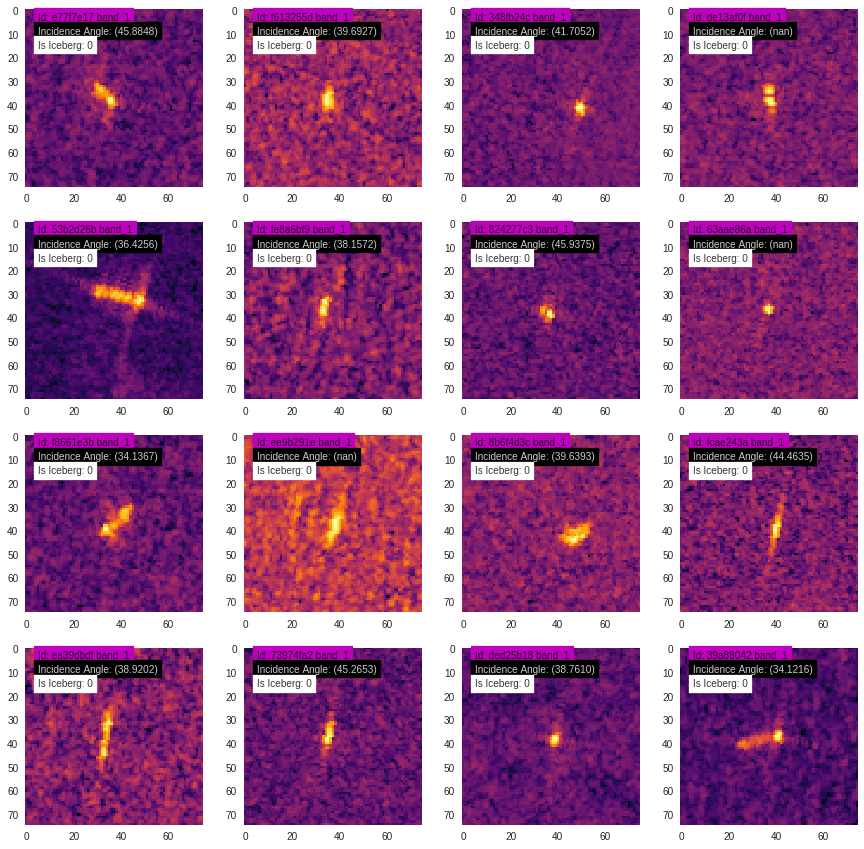

In [13]:
#plot ships
plot_band(train[train["is_iceberg"]==0], 1,size=4)

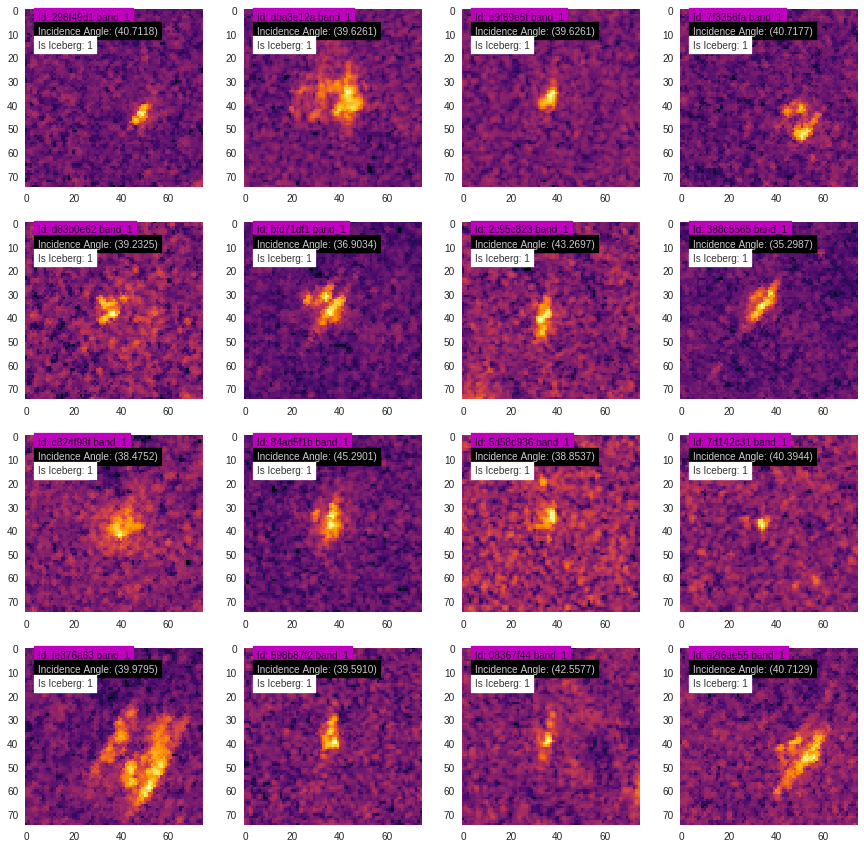

In [14]:
#plot iceberg
plot_band(train[train["is_iceberg"]==1], 1,size=4)

In [15]:
#plot comparison between band_1 and band_2:
def plot_compband(df,size=4):
    df = df.sample(n=size*size,random_state=42)
    fig = plt.figure(1,figsize=(15,15))
    for i in range(size*size):
        ax = fig.add_subplot(size,size,i+1)
        arr = np.reshape(np.array(df.iloc[i,i%2]),(75,75))
        ax.imshow(arr,cmap='inferno')
        ax.text(5, 4, 'Id: %s %s' % (df.iloc[i,2], df.columns[i%2]), color='k', backgroundcolor='m', alpha=0.8)
        ax.text(5, 10, 'inc_angle: (%.4f)' % df.iloc[i,3], color='w', backgroundcolor='k', alpha=0.8)
        try:
            ax.text(5, 16, 'is_iceberg: %s' % df.iloc[i,4], color='k', backgroundcolor='w', alpha=0.8)
        except:
            pass
        ax.grid()

    plt.show()

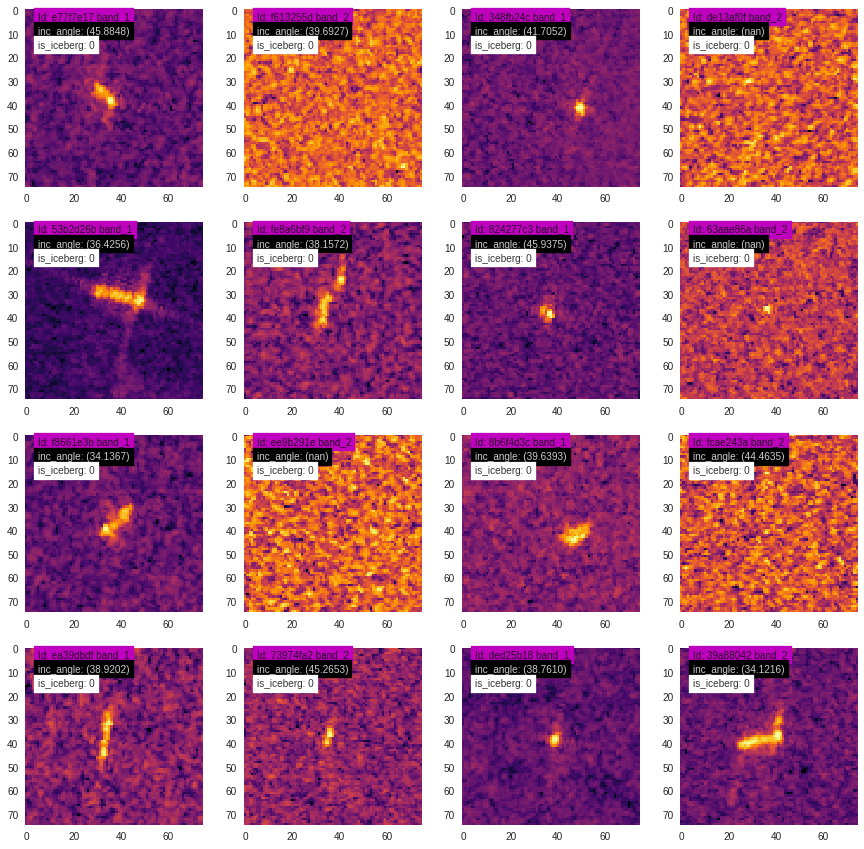

In [16]:
plot_compband(train[train["is_iceberg"]==0])

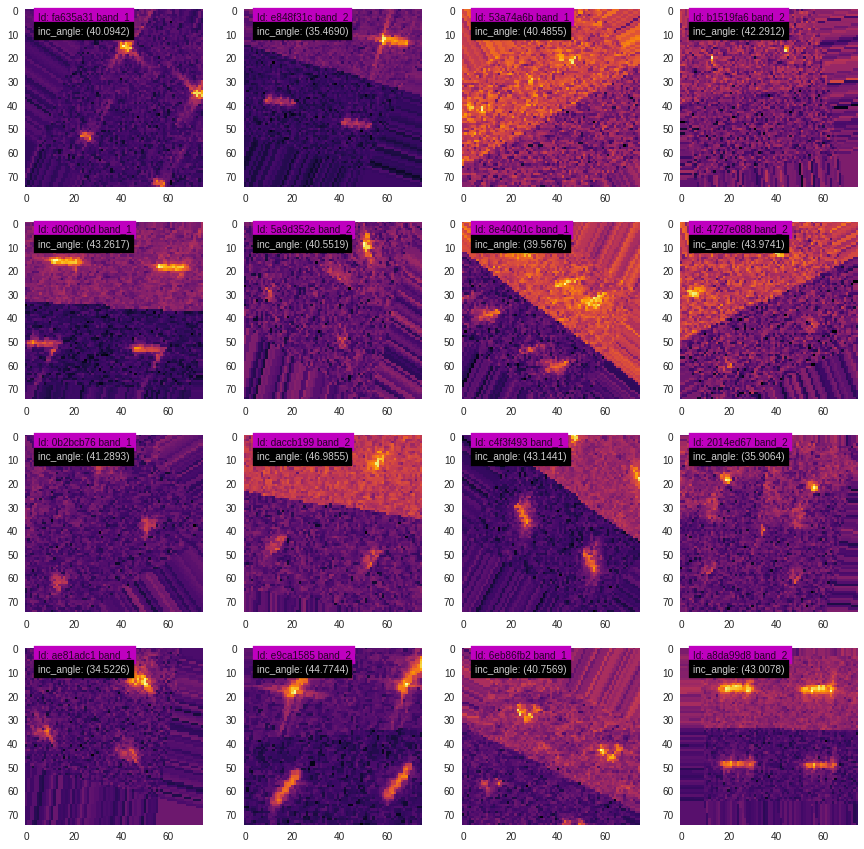

In [17]:
plot_compband(test[(test['inc_angle'].apply(lambda x: len(str(x).split(".")[1])) > 4)])

** WARNING : It looks like images with incidence angles having less than or equal to 4 decimal places (like all of those in the training set) are the naturally captured images, and those with greater precision are machine generated.** 

In [18]:
temp = (test['inc_angle'].apply(lambda x: len(str(x).split(".")[1])) > 4).sum()
print('~%.1f%% of the test data is machine generated' \
      %(100 *temp/float(len(test))))
print('\tThere are %i naturally captured images in the test set' % temp) 

~59.3% of the test data is machine generated
	There are 4999 naturally captured images in the test set


> ** First interpretations : **
- Image data integrity is correct, no corruption at first sight.
- Artificial images have been generated by an agorithm that performed rotations, flips and zoom in other images of the same set

## II. Global Statistical Analysis

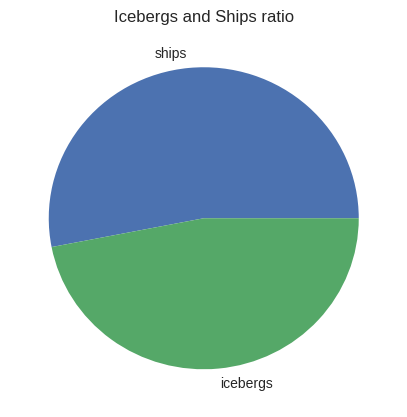

In [19]:
fig = plt.figure(figsize=(5,5),dpi=100)
temp = train.groupby(train.is_iceberg).size()
temp = plt.pie(temp, labels=["ships","icebergs"])
plt.title("Icebergs and Ships ratio")
plt.show()

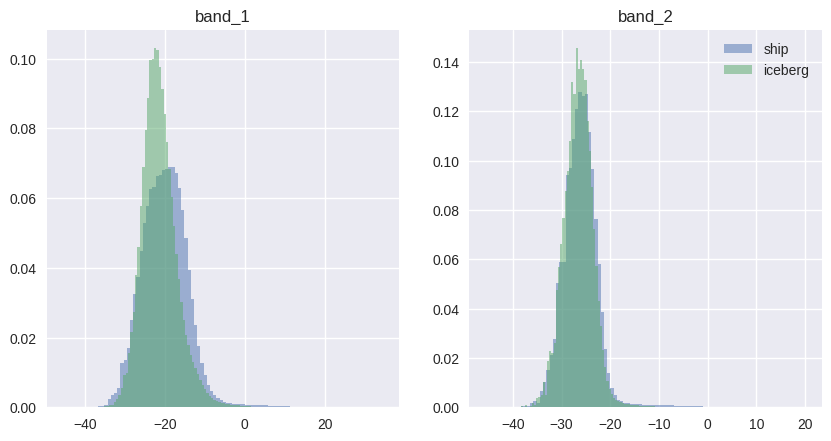

In [20]:
#plot histogram
alpha = 0.5
samples_ship = train.index[train['is_iceberg'] == 0]
samples_iceberg = train.index[train['is_iceberg'] == 1]
bands_1 = np.stack([np.array(band).reshape(75, 75) for band in train['band_1']], axis=0)
bands_2 = np.stack([np.array(band).reshape(75, 75) for band in train['band_2']], axis=0)

fig, axss = plt.subplots(1, 2, squeeze=False, figsize=(10, 5),dpi=100)
_ = axss[0,0].hist(bands_1[samples_ship, :, :].flatten(), 
                   bins=100, normed=True, alpha=alpha, label='ship')
_ = axss[0,1].hist(bands_2[samples_ship, :, :].flatten(), 
                   bins=100, normed=True, alpha=alpha, label='ship')
_ = axss[0,0].hist(bands_1[samples_iceberg, :, :].flatten(), 
                   bins=100, normed=True, alpha=alpha, label='iceberg')
_ = axss[0,1].hist(bands_2[samples_iceberg, :, :].flatten(), 
                   bins=100, normed=True, alpha=alpha, label='iceberg')
temp=axss[0, 0].set_title('band_1')
temp=axss[0, 1].set_title('band_2')
temp=axss[0, 1].legend()

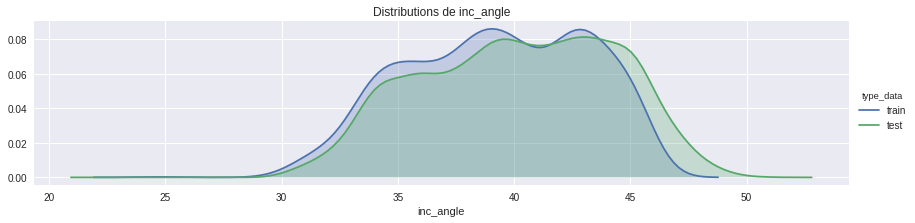

In [25]:
#Disttibution between train and test
data=pd.concat([train,test])
data['type_data']=['train'] * len(train) + ['test']*len(test) #car concaténation simple des deux data sets


liste_var=['inc_angle']
fig = plt.figure(figsize=(8,4),dpi=150)
for var in liste_var:
    #pdensity plot
    try:
        facet = sns.FacetGrid(data, hue="type_data",aspect=4) #palette="Blues_d"
        facet.map(sns.kdeplot,var,shade= True)
        plt.title('Distributions de %s' %(var))
        facet.add_legend()
        plt.show()
    except Exception as e:
        print("Error ploting %s à cause de l'erreur : %s" %(var,e))
        

> Slight shift on inc_angle between train and test